In [1]:
from ydata_profiling import ProfileReport
import pandas as pd
import numpy as np
import pandas_datareader as pdr  # to install: !pip install pandas_datareader
from datetime import datetime
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols as sm_ols
from statsmodels.iolib.summary2 import summary_col # nicer tables
from sklearn.model_selection import train_test_split
from sklearn import set_config
from sklearn.calibration import CalibrationDisplay
from sklearn.compose import ColumnTransformer, make_column_selector, make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay,DetCurveDisplay,PrecisionRecallDisplay,RocCurveDisplay,classification_report,r2_score
from sklearn.model_selection import GridSearchCV,KFold,cross_validate,train_test_split
from df_after_transform import df_after_transform
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.linear_model import Lasso, Ridge
from sklearn.feature_selection import SelectKBest, f_classif, VarianceThreshold
set_config(display="diagram")

In [2]:
ceo_df = pd.read_csv('./input_data_clean/CEO_DF.csv')
bod_df = pd.read_csv('./input_data_clean/BOD_DF.csv')
firms_df = pd.read_csv('./input_data_clean/FIRMS.csv')

In [3]:
tiny_ceo_df = ceo_df[ceo_df['size_category'] == 'Tiny']
medium_ceo_df = ceo_df[ceo_df['size_category'] == 'Medium']
big_ceo_df = ceo_df[ceo_df['size_category'] == 'Big']
huge_ceo_df = ceo_df[ceo_df['size_category'] == 'Huge']

tiny_bod_df = bod_df[bod_df['size_category'] == 'Tiny']
medium_bod_df = bod_df[bod_df['size_category'] == 'Medium']
big_bod_df = bod_df[bod_df['size_category'] == 'Big']
huge_bod_df = bod_df[bod_df['size_category'] == 'Huge']



list_ceo_df = [tiny_ceo_df, medium_ceo_df, big_ceo_df, huge_ceo_df]
list_bod_df = [tiny_bod_df, medium_bod_df, big_bod_df, huge_bod_df]

In [4]:
df = tiny_ceo_df
df.drop(['Unnamed: 0', 'gvkey'], axis=1, inplace=True)
df.drop('ownershipratio', axis=1, inplace=True)

# Create boolean masks for the train and holdout periods
train_mask = df.loc[(df['year'] >= 2010) & (df['year'] <= 2016)]
holdout_mask = df.loc[(df['year'] >= 2017) & (df['year'] <= 2019)]

y = np.log(train_mask.tdc1)
X = train_mask.drop('tdc1', axis=1)

VarY = holdout_mask[['signature_index', 'tdc1']].to_csv('Saved/tiny_ceo_df.csv', index=False)
holdout_X = holdout_mask.drop('tdc1', axis=1)

rng = np.random.RandomState(0)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=rng)



/var/folders/29/vl12lkgs28xgjpc6t0_jg9040000gn/T/ipykernel_2794/364529595.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(['Unnamed: 0', 'gvkey'], axis=1, inplace=True)
/var/folders/29/vl12lkgs28xgjpc6t0_jg9040000gn/T/ipykernel_2794/364529595.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop('ownershipratio', axis=1, inplace=True)


In [5]:
cv = KFold(5)

In [6]:
numer_pipe = make_pipeline(SimpleImputer(strategy="mean"), StandardScaler())
cat_pipe = make_pipeline(OneHotEncoder())

preproc_pipe = make_column_transformer(
    (numer_pipe, make_column_selector(dtype_include=np.number)),
    (cat_pipe, ['gender']),
    remainder="drop",
)
# pipe = Pipeline([('columntransformer',preproc_pipe),
#                  ('feature_select',SelectKBest()), 
#                  ('clf', Ridge())
#                 ])

ridge_pipe = Pipeline([
    ('preprocessor', preproc_pipe),
    ('ridge', Ridge())
])

In [7]:
alphas = list(np.linspace(0, 300, 25))
parameters = {'ridge__alpha': alphas}

grid_search = GridSearchCV(estimator=ridge_pipe, 
                           param_grid=parameters,
                           cv=cv,
                           scoring='r2',
                           error_score='raise')

results = grid_search.fit(X_train, y_train)

<AxesSubplot:title={'center':'CV score by alpha'}, xlabel='alpha'>

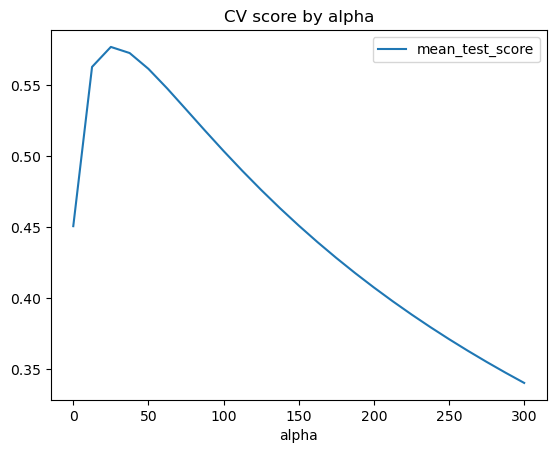

In [8]:
results_df = pd.DataFrame(results.cv_results_).set_index('params')
results_df['alpha'] = [c['ridge__alpha'] for c in results_df.index]
results_df = results_df.sort_values('alpha')
results_df.plot(x='alpha', y='mean_test_score', kind='line', title='CV score by alpha')

<AxesSubplot:title={'center':'CV score by alpha'}, xlabel='alpha'>

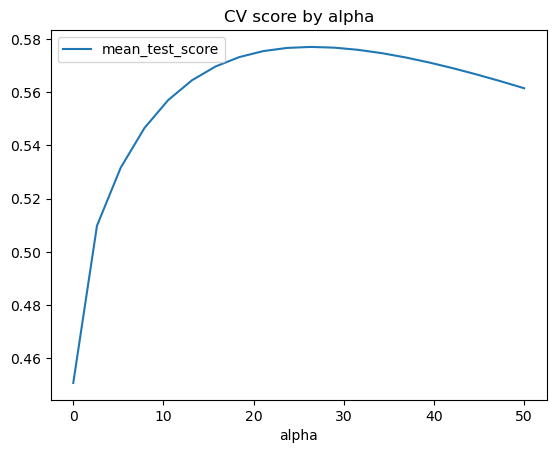

In [9]:
alphas = list(np.linspace(0,50,20))
parameters = {'ridge__alpha': alphas}

grid_search = GridSearchCV(estimator=ridge_pipe, 
                           param_grid=parameters,
                           cv=cv,
                           scoring='r2')

results = grid_search.fit(X_train, y_train)

results_df = pd.DataFrame(results.cv_results_).set_index('params')
# extract alpha from the params variable
results_df['alpha'] = [c['ridge__alpha'] for c in results_df.index]
results_df = results_df.sort_values('alpha')
results_df.plot(x='alpha',y='mean_test_score',kind='line',
                title='CV score by alpha')

In [10]:
##### 0.00184
best_alpha = results_df.query('rank_test_score == 1')['param_ridge__alpha'][0]
print('The optimal ridge alpha is: %.5f' % best_alpha)

The optimal ridge alpha is: 26.31579


In [11]:
print('The mean test score for this alpha is: %.5f' % results_df.query('rank_test_score == 1')['mean_test_score'][0])

The mean test score for this alpha is: 0.57700


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 113 entries, 1 to 10709
Data columns (total 24 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ticker           113 non-null    object 
 1   ceoann           113 non-null    object 
 2   salary           113 non-null    float64
 3   bonus            113 non-null    float64
 4   stock_awards     113 non-null    float64
 5   option_awards    113 non-null    float64
 6   othcomp          113 non-null    float64
 7   total_curr       113 non-null    float64
 8   age              113 non-null    float64
 9   tdc1             113 non-null    float64
 10  year             113 non-null    int64  
 11  becameceo        110 non-null    float64
 12  joined_co        19 non-null     float64
 13  leftofc          69 non-null     float64
 14  gender           113 non-null    object 
 15  cusip            113 non-null    int64  
 16  naicsdesc        113 non-null    int64  
 17  sic           